# Threshold moving for Random Forest Models

In [2]:
from IPython.core.interactiveshell import InteractiveShell
from matplotlib import pyplot
import numpy as np
from numpy import mean
from numpy import nanargmax
from numpy import std
from sklearn.calibration import CalibratedClassifierCV as CCCV
from sklearn.calibration import calibration_curve
from sklearn.datasets import make_classification
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix as confusion
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score as recall
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import pandas as pd
InteractiveShell.ast_node_interactivity = "all"

In [3]:
#Defining the search space for all LR models
space=dict()
space['n_estimators']=[10, 50, 100, 250, 500]
space['max_features']=[10, 50, 200, 500]
space['min_samples_split']=[2, 10, 50]
#Defining model parameters
RF= RandomForestClassifier(random_state=42)
cv=KFold(n_splits=5, shuffle=True, random_state=26)
searchRF=RandomizedSearchCV(RF, space, scoring='roc_auc', n_jobs=-1,n_iter=30, refit=True, cv=cv, random_state=26)

## Suicidal ideation threshold moving

In [17]:
#Reading the dataframes produced from the LR_Threshs notebook
X55=pd.read_csv(r'C:\Users\z5291979\OneDrive - UNSW\Documents\lsac-data\processed_data\X55_si.csv')
X15=pd.read_csv(r'C:\Users\z5291979\OneDrive - UNSW\Documents\lsac-data\processed_data\X15_si.csv')
y55=pd.read_csv(r'C:\Users\z5291979\OneDrive - UNSW\Documents\lsac-data\processed_data\y55_si.csv', header=None)
y15=pd.read_csv(r'C:\Users\z5291979\OneDrive - UNSW\Documents\lsac-data\processed_data\y15_si.csv', header=None)


In [13]:
np.average(y55)

0.13305613305613306

In [34]:
searchRF.fit(X55, y55)
searchRF.best_params_

c:\Users\z5291979\OneDrive - UNSW\Documents\lsac-data\lsac-suicidality\venv\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=26, shuffle=True),
                   estimator=RandomForestClassifier(random_state=42), n_iter=30,
                   n_jobs=-1,
                   param_distributions={'max_features': [10, 50, 200, 500],
                                        'min_samples_split': [2, 10, 50],
                                        'n_estimators': [10, 50, 100, 250,
                                                         500]},
                   random_state=26, scoring='roc_auc')

{'n_estimators': 50, 'min_samples_split': 50, 'max_features': 200}

In [35]:
#Calibrating the best classifier
cRF=CCCV(searchRF.best_estimator_, method='isotonic')
cRF.fit(X55, y55)
probac=cRF.predict_proba(X55)

c:\Users\z5291979\OneDrive - UNSW\Documents\lsac-data\lsac-suicidality\venv\lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\z5291979\OneDrive - UNSW\Documents\lsac-data\lsac-suicidality\venv\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\z5291979\OneDrive - UNSW\Documents\lsac-data\lsac-suicidality\venv\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\z5291979\OneDrive - UNSW\Documents

CalibratedClassifierCV(estimator=RandomForestClassifier(max_features=200,
                                                        min_samples_split=50,
                                                        n_estimators=50,
                                                        random_state=42),
                       method='isotonic')

In [36]:
probac=probac[:, 1]
print('Probs: %.3f (%.3f)' % (mean(probac), std(probac)) )

Probs: 0.138 (0.188)


In [4]:
#Creating a function that displays fpr, tpr, ROC curve, AUROC, and best threshold 
def tuning(y55, probac):
    fpr, tpr, thresholds=roc_curve(y55, probac)
    #Calculating AUROC in training data
    print(f'AUROC={roc_auc_score(y55, probac):f}')
    #Deriving the optimal threshold using Youden's J statistic 
    J = tpr - fpr
    ix = nanargmax(J)
    best_thresh = thresholds[ix]
    print('Best Threshold=%f' % (best_thresh))
    # plot the roc curve for the model, 
    pyplot.plot([0,1], [0,1], linestyle='--', label='Baseline')
    pyplot.plot(fpr, tpr, marker='.', label='RF')
    pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
    # axis labels
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    pyplot.legend()
    # show the plot
    pyplot.show()

    return best_thresh

AUROC=0.972155
Best Threshold=0.175579


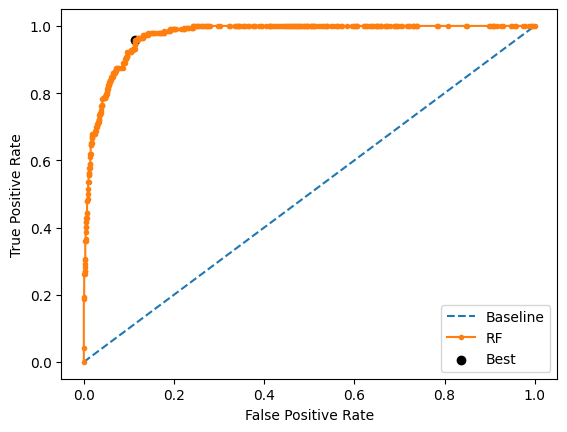

In [38]:
best_thresh=tuning(y55, probac)

In [5]:
#Defining a function that displays probability thresholds by percentiles
def threshp(probac):
    for i in np.arange(80, 100, 5):
        print("Top", 100-i, "% of predicted risk=", np.percentile(probac, i) )

In [40]:
threshp(probac)

Top 20 % of predicted risk= 0.20818370700584704
Top 15 % of predicted risk= 0.33066625812609074
Top 10 % of predicted risk= 0.44695881609827515
Top 5 % of predicted risk= 0.5810960850743457


In [41]:
yprob=cRF.predict_proba(X15)
yprob=yprob[:, 1]
print('Probs: %.3f (%.3f)' % (mean(yprob), std(yprob)) )

Probs: 0.110 (0.135)


In [6]:
#Defining a function to examine calibration curve
def ccurve(y15, yprob, n_bins=10):
    # reliability diagram
    fop, mpv = calibration_curve(y15, yprob, n_bins=10)
    # plot perfectly calibrated
    pyplot.plot([0, 1], [0, 1], linestyle='--')
    # plot model reliability
    pyplot.xlabel('Predicted probability')
    pyplot.ylabel('True probability')
    pyplot.plot(mpv, fop, marker='.')
    pyplot.show()

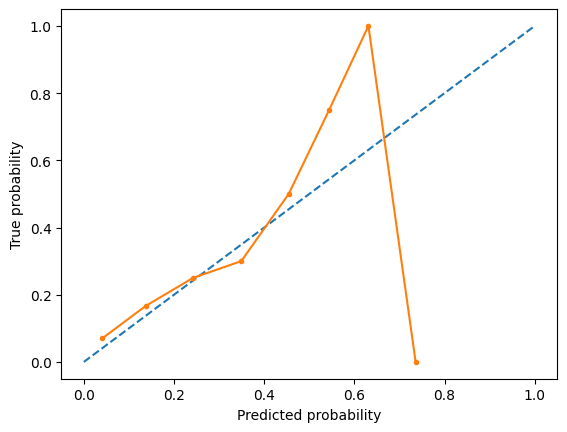

In [43]:
ccurve(y15, yprob)

In [7]:
#Creating a function which evaluates the best theshold derived from Youden's
def eval(y15, yprob, best_thresh):
    ypred=np.where(yprob>best_thresh, 1, 0)
    f1= f1_score(y15, ypred)
    print(f'F1= {f1:f}')
    sens= recall(y15, ypred)
    print(f'Sensitivity= {sens:f}')
    tn, fp, fn, tp= confusion(y15, ypred).ravel()
    spec=tn/(tn+fp)
    print(f'Specificity= {spec:f}')
    auc= roc_auc_score(y15, yprob)
    print(f'AUROC= {auc:f}')

    return f1, auc, sens, spec


In [45]:

eval(y15, yprob, best_thresh)

F1= 0.395062
Sensitivity= 0.470588
Specificity= 0.859729
AUROC= 0.738555


(0.39506172839506176,
 0.7385546978972584,
 0.47058823529411764,
 0.8597285067873304)

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

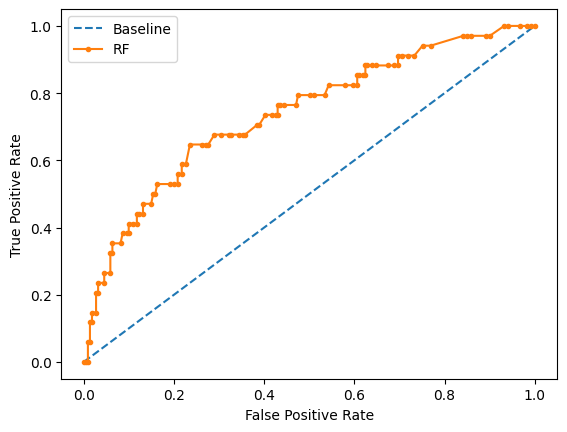

In [46]:
fpr, tpr, thresholds=roc_curve(y15, yprob)    
# plot the roc curve for the model, 
pyplot.plot([0,1], [0,1], linestyle='--', label='Baseline')
pyplot.plot(fpr, tpr, marker='.', label='RF')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()


### Self-harm threshold moving

In [55]:
X55=pd.read_csv(r'C:\Users\z5291979\OneDrive - UNSW\Documents\lsac-data\processed_data\X55_nssi.csv')
X15=pd.read_csv(r'C:\Users\z5291979\OneDrive - UNSW\Documents\lsac-data\processed_data\X15_nssi.csv')
y55=pd.read_csv(r'C:\Users\z5291979\OneDrive - UNSW\Documents\lsac-data\processed_data\y55_nssi.csv')
y15=pd.read_csv(r'C:\Users\z5291979\OneDrive - UNSW\Documents\lsac-data\processed_data\y15_nssi.csv')
np.average(y55)

0.07686980609418283

In [66]:
searchRF=RandomizedSearchCV(RF, space, scoring='roc_auc', n_jobs=-1,n_iter=30, refit=True, cv=cv, random_state=42)
searchRF.fit(X55, y55)
searchRF.best_params_

c:\Users\z5291979\OneDrive - UNSW\Documents\lsac-data\lsac-suicidality\venv\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=26, shuffle=True),
                   estimator=RandomForestClassifier(random_state=42), n_iter=30,
                   n_jobs=-1,
                   param_distributions={'max_features': [10, 50, 200, 500],
                                        'min_samples_split': [2, 10, 50],
                                        'n_estimators': [10, 50, 100, 250,
                                                         500]},
                   random_state=42, scoring='roc_auc')

{'n_estimators': 100, 'min_samples_split': 50, 'max_features': 50}

In [67]:
#Calibrating the best classifier
cRF=CCCV(searchRF.best_estimator_, method='isotonic')
cRF.fit(X55, y55)
probac=cRF.predict_proba(X55)

c:\Users\z5291979\OneDrive - UNSW\Documents\lsac-data\lsac-suicidality\venv\lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\z5291979\OneDrive - UNSW\Documents\lsac-data\lsac-suicidality\venv\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\z5291979\OneDrive - UNSW\Documents\lsac-data\lsac-suicidality\venv\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\z5291979\OneDrive - UNSW\Documents

CalibratedClassifierCV(estimator=RandomForestClassifier(max_features=50,
                                                        min_samples_split=50,
                                                        random_state=42),
                       method='isotonic')

In [68]:
probac=probac[:, 1]
print('Probs: %.3f (%.3f)' % (mean(probac), std(probac)) )

Probs: 0.083 (0.148)


AUROC=0.976835
Best Threshold=0.160344


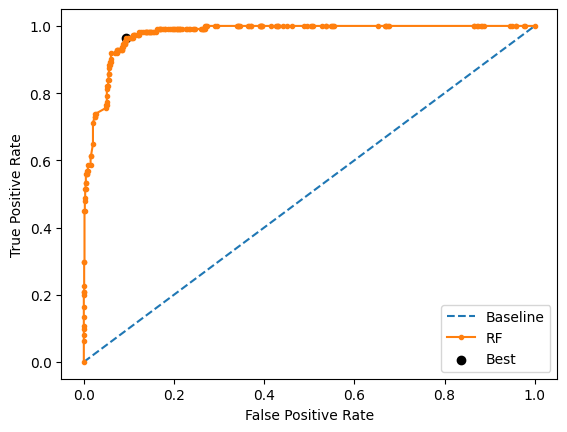

In [69]:
best_thresh=tuning(y55, probac)

In [71]:
threshp(probac)

Top 20 % of predicted risk= 0.09884759951964982
Top 15 % of predicted risk= 0.17281868372021555
Top 10 % of predicted risk= 0.24825130689787073
Top 5 % of predicted risk= 0.2844795336198131


In [72]:
yprob=cRF.predict_proba(X15)
yprob=yprob[:, 1]
print('Probs: %.3f (%.3f)' % (mean(yprob), std(yprob)) )

Probs: 0.079 (0.114)


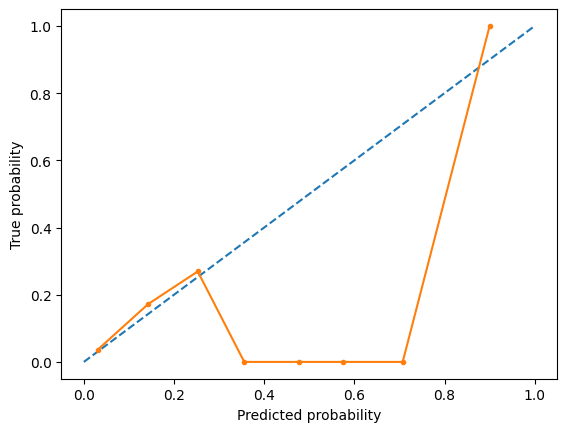

In [73]:
ccurve(y15, yprob)

In [74]:

eval(y15, yprob, best_thresh)

F1= 0.258065
Sensitivity= 0.400000
Specificity= 0.855319
AUROC= 0.773617


(0.25806451612903225, 0.7736170212765958, 0.4, 0.8553191489361702)

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

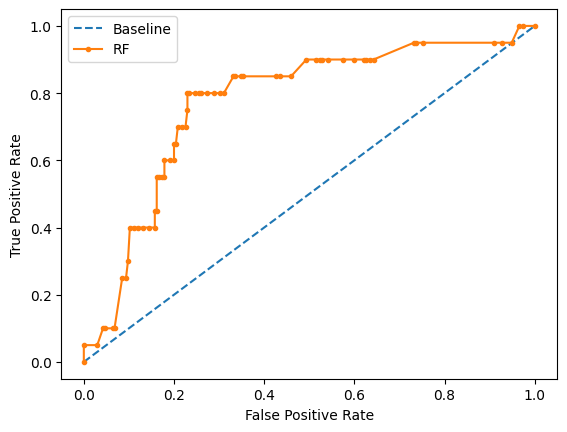

In [75]:
fpr, tpr, thresholds=roc_curve(y15, yprob)    
# plot the roc curve for the model, 
pyplot.plot([0,1], [0,1], linestyle='--', label='Baseline')
pyplot.plot(fpr, tpr, marker='.', label='RF')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()


### Attempt threshold moving

In [76]:
#Dividing the training dataset using stratified split for threshold moving 
X55=pd.read_csv(r'C:\Users\z5291979\OneDrive - UNSW\Documents\lsac-data\processed_data\X55_att.csv')
X15=pd.read_csv(r'C:\Users\z5291979\OneDrive - UNSW\Documents\lsac-data\processed_data\X15_att.csv')
y55=pd.read_csv(r'C:\Users\z5291979\OneDrive - UNSW\Documents\lsac-data\processed_data\y55_att.csv')
y15=pd.read_csv(r'C:\Users\z5291979\OneDrive - UNSW\Documents\lsac-data\processed_data\y15_att.csv')
np.average(y55)

0.04293628808864266

In [77]:
searchRF.fit(X55, y55)
searchRF.best_params_

c:\Users\z5291979\OneDrive - UNSW\Documents\lsac-data\lsac-suicidality\venv\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=26, shuffle=True),
                   estimator=RandomForestClassifier(random_state=42), n_iter=30,
                   n_jobs=-1,
                   param_distributions={'max_features': [10, 50, 200, 500],
                                        'min_samples_split': [2, 10, 50],
                                        'n_estimators': [10, 50, 100, 250,
                                                         500]},
                   random_state=42, scoring='roc_auc')

{'n_estimators': 250, 'min_samples_split': 50, 'max_features': 10}

In [78]:
#Calibrating the best classifier
cRF=CCCV(searchRF.best_estimator_, method='isotonic')
cRF.fit(X55, y55)
probac=cRF.predict_proba(X55)

c:\Users\z5291979\OneDrive - UNSW\Documents\lsac-data\lsac-suicidality\venv\lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\z5291979\OneDrive - UNSW\Documents\lsac-data\lsac-suicidality\venv\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\z5291979\OneDrive - UNSW\Documents\lsac-data\lsac-suicidality\venv\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\z5291979\OneDrive - UNSW\Documents

CalibratedClassifierCV(estimator=RandomForestClassifier(max_features=10,
                                                        min_samples_split=50,
                                                        n_estimators=250,
                                                        random_state=42),
                       method='isotonic')

In [79]:
probac=probac[:, 1]
print('Probs: %.3f (%.3f)' % (mean(probac), std(probac)) )

Probs: 0.046 (0.089)


AUROC=0.988213
Best Threshold=0.073374


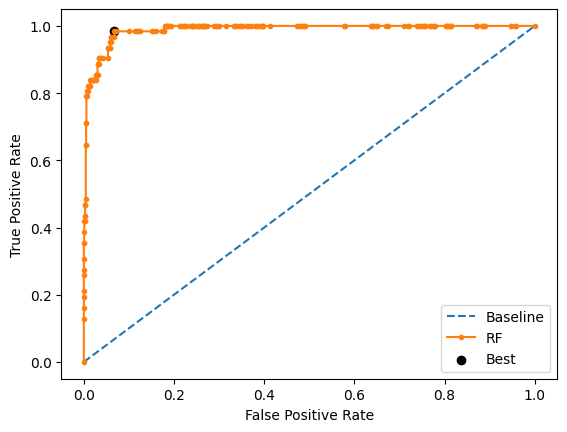

In [80]:
best_thresh=tuning(y55, probac)

In [81]:
threshp(probac)

Top 20 % of predicted risk= 0.060600401689620734
Top 15 % of predicted risk= 0.07253317479886444
Top 10 % of predicted risk= 0.07356054499459164
Top 5 % of predicted risk= 0.18459955990011956


In [82]:
yprob=cRF.predict_proba(X15)
yprob=yprob[:, 1]
print('Probs: %.3f (%.3f)' % (mean(yprob), std(yprob)) )

Probs: 0.039 (0.055)


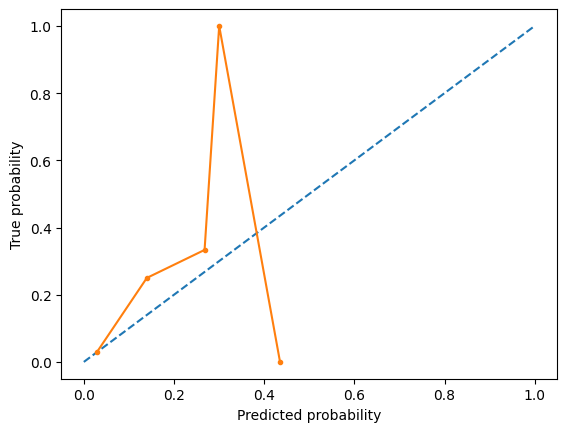

In [83]:
ccurve(y15, yprob)

In [84]:
eval(y15, yprob, best_thresh)

F1= 0.228571
Sensitivity= 0.363636
Specificity= 0.918033
AUROC= 0.882265


(0.2285714285714286,
 0.8822652757078987,
 0.36363636363636365,
 0.9180327868852459)

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

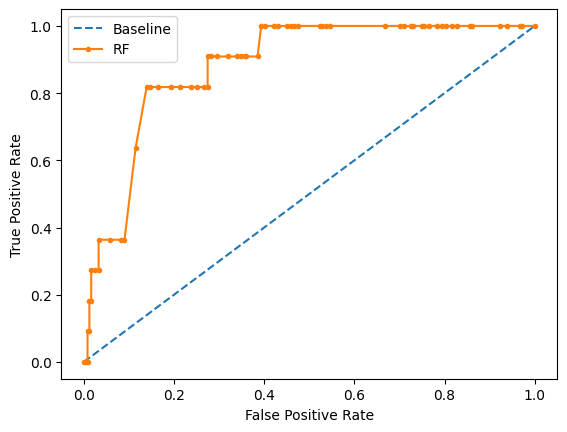

In [85]:
fpr, tpr, thresholds=roc_curve(y15, yprob)    
# plot the roc curve for the model, 
pyplot.plot([0,1], [0,1], linestyle='--', label='Baseline')
pyplot.plot(fpr, tpr, marker='.', label='RF')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()


### SITB threshold moving

In [8]:
#Dividing the training dataset using stratified split for threshold moving 
X55=pd.read_csv(r'C:\Users\z5291979\OneDrive - UNSW\Documents\lsac-data\processed_data\X55_sitbs.csv')
X15=pd.read_csv(r'C:\Users\z5291979\OneDrive - UNSW\Documents\lsac-data\processed_data\X15_sitbs.csv')
y55=pd.read_csv(r'C:\Users\z5291979\OneDrive - UNSW\Documents\lsac-data\processed_data\y55_sitbs.csv')
y15=pd.read_csv(r'C:\Users\z5291979\OneDrive - UNSW\Documents\lsac-data\processed_data\y15_sitbs.csv')
np.average(y55)

0.16620498614958448

In [22]:
RF= RandomForestClassifier(random_state=2032)
searchRF=RandomizedSearchCV(RF, space, scoring='roc_auc', n_jobs=-1,n_iter=30, refit=True, cv=10, random_state=500)
searchRF.fit(X55, y55)
searchRF.best_params_

c:\Users\z5291979\OneDrive - UNSW\Documents\lsac-data\lsac-suicidality\venv\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(random_state=2032),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'max_features': [10, 50, 200, 500],
                                        'min_samples_split': [2, 10, 50],
                                        'n_estimators': [10, 50, 100, 250,
                                                         500]},
                   random_state=500, scoring='roc_auc')

{'n_estimators': 250, 'min_samples_split': 50, 'max_features': 200}

In [23]:
#Calibrating the best classifier
cRF=CCCV(searchRF.best_estimator_, method='isotonic')
cRF.fit(X55, y55)
probac=cRF.predict_proba(X55)

c:\Users\z5291979\OneDrive - UNSW\Documents\lsac-data\lsac-suicidality\venv\lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\z5291979\OneDrive - UNSW\Documents\lsac-data\lsac-suicidality\venv\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\z5291979\OneDrive - UNSW\Documents\lsac-data\lsac-suicidality\venv\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\z5291979\OneDrive - UNSW\Documents

CalibratedClassifierCV(estimator=RandomForestClassifier(max_features=200,
                                                        min_samples_split=50,
                                                        n_estimators=250,
                                                        random_state=2032),
                       method='isotonic')

In [24]:
probac=probac[:, 1]
print('Probs: %.3f (%.3f)' % (mean(probac), std(probac)) )

Probs: 0.172 (0.202)


AUROC=0.961822
Best Threshold=0.152130


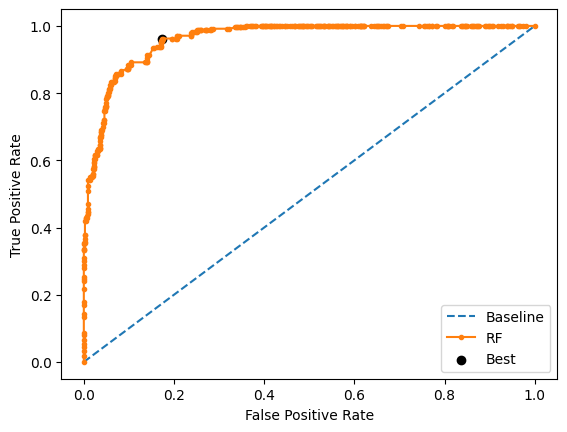

In [25]:
best_thresh=tuning(y55, probac)

In [26]:
threshp(probac)

Top 20 % of predicted risk= 0.2490152920585968
Top 15 % of predicted risk= 0.4066397416830461
Top 10 % of predicted risk= 0.5080058099794942
Top 5 % of predicted risk= 0.6395534290271132


In [27]:
yprob=cRF.predict_proba(X15)
yprob=yprob[:, 1]
print('Probs: %.3f (%.3f)' % (mean(yprob), std(yprob)) )

Probs: 0.163 (0.170)


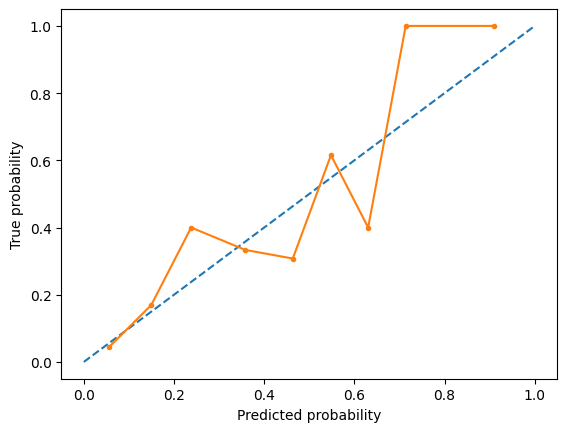

In [28]:
ccurve(y15, yprob)

In [33]:
def eval(y15, yprob, best_thresh):
    ypred=np.where(yprob>best_thresh, 1, 0)
    f1= f1_score(y15, ypred)
    print(f'F1= {f1:f}')
    sens= recall(y15, ypred)
    print(f'Sensitivity= {sens:f}')
    tn, fp, fn, tp= confusion(y15, ypred).ravel()
    spec=tn/(tn+fp)
    print(f'Specificity= {spec:f}')
    auc= roc_auc_score(y15, yprob)
    print(f'AUROC= {auc:f}')

    return f1, auc, sens, spec, ypred

In [44]:
f1, auc, sens, spec, ypred=eval(y15, yprob, best_thresh)

F1= 0.464000
Sensitivity= 0.690476
Specificity= 0.746479
AUROC= 0.802482


Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

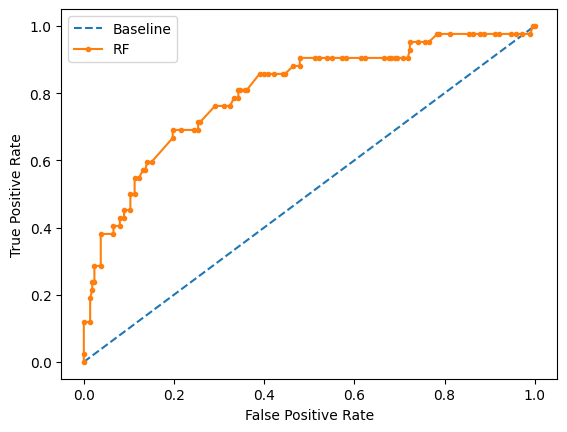

In [47]:
fpr, tpr, thresholds=roc_curve(y15, yprob)    
# plot the roc curve for the model, 
pyplot.plot([0,1], [0,1], linestyle='--', label='Baseline')
pyplot.plot(fpr, tpr, marker='.', label='RF')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()
